In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import pickle

In [2]:
# On the kaggle notebook

# we only take the first 2000 from the training set

# and only the first 1000 from the test set

# REMOVE [0:2000] and [0:1000] when running locally

NumTrain = 10000

TRAIN_DIR = '../Train/train/'

TEST_DIR = 'input/test'

train_image_file_names = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)][0:NumTrain] 

In [3]:
# Slow, yet simple implementation with tensorflow
# could be rewritten to be much faster
# (which is not really needed as it takes less than 5 minutes on my laptop)

def decode_image(image_file_names, resize_func=None):

    images = []

    graph = tf.Graph()
    with graph.as_default():
        file_name = tf.placeholder(dtype=tf.string)
        file = tf.read_file(file_name)
        image = tf.image.decode_jpeg(file)
        if resize_func != None:
            image = resize_func(image)

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()   
        for i in range(len(image_file_names)):
            images.append(session.run(image, feed_dict={file_name: image_file_names[i]}))
            if (i+1) % 1000 == 0:
                print('Images processed: ',i+1)

        session.close()

    return images

In [4]:
train_images = decode_image(train_image_file_names)

('Images processed: ', 1000)
('Images processed: ', 2000)
('Images processed: ', 3000)
('Images processed: ', 4000)
('Images processed: ', 5000)
('Images processed: ', 6000)
('Images processed: ', 7000)
('Images processed: ', 8000)
('Images processed: ', 9000)
('Images processed: ', 10000)


In [5]:
# Check mean aspect ratio (width/height), mean width and mean height
width = []
height = []
aspect_ratio = []
for image in train_images:
    h, w, d = np.shape(image)
    aspect_ratio.append(float(w) / float(h))
    width.append(w)
    height.append(h)

('Mean width:', 403.91820000000001)
('Mean height:', 359.04669999999999)


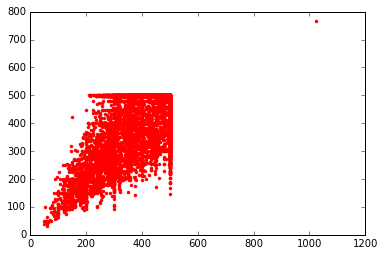

In [6]:
print('Mean width:',np.mean(width))
print('Mean height:',np.mean(height))
plt.plot(width, height, '.r')
plt.show()

In [7]:
print("Images widther than 500 pixel: ", np.sum(np.array(width) > 500))
print("Images higher than 500 pixel: ", np.sum(np.array(height) > 500))

('Images widther than 500 pixel: ', 1)
('Images higher than 500 pixel: ', 1)


In [8]:
# Free up some memory
del train_images
#del test_images
#del all_images

In [9]:
WIDTH=300
HEIGHT=300
resize_func = lambda image: tf.image.resize_image_with_crop_or_pad(image, HEIGHT, WIDTH)

In [10]:
processed_train_images = decode_image(train_image_file_names, resize_func=resize_func)

('Images processed: ', 1000)
('Images processed: ', 2000)
('Images processed: ', 3000)
('Images processed: ', 4000)
('Images processed: ', 5000)
('Images processed: ', 6000)
('Images processed: ', 7000)
('Images processed: ', 8000)
('Images processed: ', 9000)
('Images processed: ', 10000)


In [11]:
print(np.shape(processed_train_images))

(10000, 300, 300, 3)


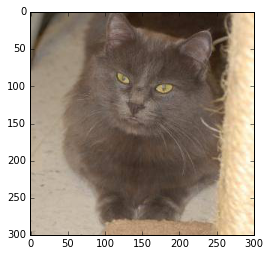

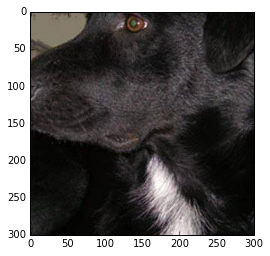

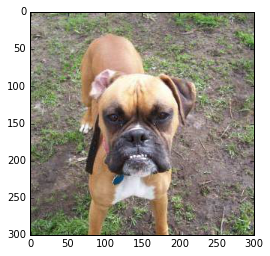

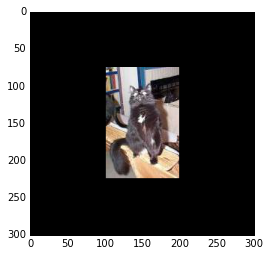

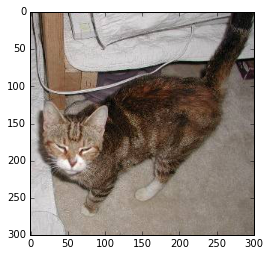

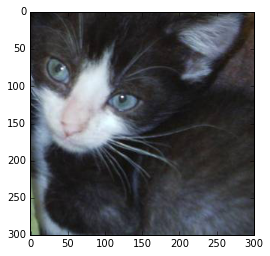

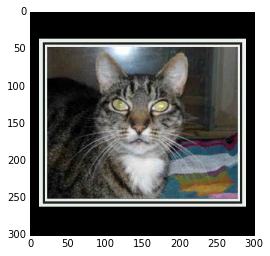

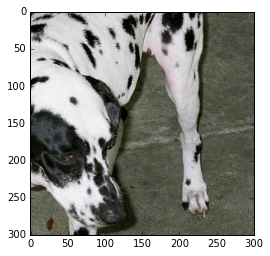

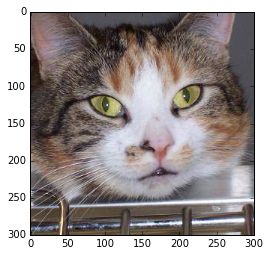

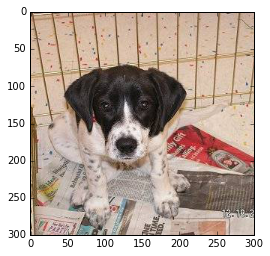

In [12]:
for i in range(10):
    plt.imshow(processed_train_images[i])
    plt.show()

In [13]:
#!pip install tqdm
#!pip install tflearn

In [14]:
from tqdm import tqdm
X_train = []
for i in tqdm(range(NumTrain)):
    tmp = np.matrix(processed_train_images[i].reshape((WIDTH*HEIGHT*3,)))
    X_train.append(tmp)

# flatten
X_train = np.array(X_train).reshape(NumTrain,WIDTH*HEIGHT*3)

100%|██████████| 10000/10000 [00:01<00:00, 7978.32it/s]


In [15]:
X_train = X_train.astype(float)

In [16]:
X_train_mean = np.mean(X_train, axis = 1)

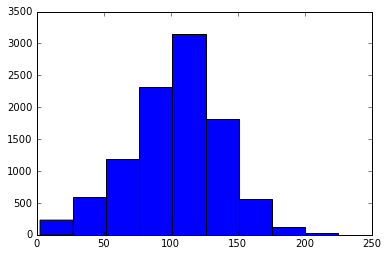

In [17]:
plt.hist(X_train_mean)
del X_train_mean

In [18]:
import pandas as pd
import re
import tflearn


In [19]:
NumTrain = 10000
WIDTH=300
HEIGHT=300

In [20]:
crit = re.compile('(Train\/train\/)((dog)|(cat))')
a = [ crit.search(elm).group(2) for elm in train_image_file_names ]
Y_train = [ [1,0] if elm == 'cat' else [0,1] for elm in a ]

In [21]:
Y_train = np.array(Y_train).astype(float)

In [22]:
from __future__ import division, print_function, absolute_import
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [23]:
X = X_train.reshape([-1, WIDTH, HEIGHT, 3])
Y = Y_train

In [24]:
# Building convolutional network
network = input_data(shape=[None, WIDTH, HEIGHT, 3], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = fully_connected(network, 128, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 256, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 2, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.002,
                     loss='categorical_crossentropy', name='target')



In [25]:
# Training
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y}, n_epoch=20,
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 366  | total loss: 0.69486
| Adam | epoch: 002 | loss: 0.69486 - acc: 0.5004 -- iter: 03328/10000


KeyboardInterrupt: 

In [ ]:
input_layer = tflearn.input_data(shape=[None, WIDTH*HEIGHT*3])

In [ ]:
dense1 = tflearn.fully_connected(input_layer, 220, activation='tanh',
                                 regularizer='L2', weight_decay=0.001)
dropout1 = tflearn.dropout(dense1, 0.7)
dense2 = tflearn.fully_connected(dropout1, 130, activation='tanh',
                                 regularizer='L2', weight_decay=0.001)
dropout2 = tflearn.dropout(dense2, 0.3)
softmax = tflearn.fully_connected(dropout2, 2, activation='softmax')

In [ ]:
sgd = tflearn.SGD(learning_rate=0.15, lr_decay=0.96, decay_step=1000)
top_k = tflearn.metrics.Top_k(3)
net = tflearn.regression(softmax, optimizer=sgd, metric=top_k,
                         loss='categorical_crossentropy')

In [ ]:
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X_train, Y_train, n_epoch=5, validation_set=(X_train, Y_train),
          show_metric=True, run_id="dense_model")

In [ ]:
model.predict(X_train[3].reshape(1,WIDTH*HEIGHT*3))

In [ ]:
Y_train[3]

# Try logistic regression.

In [ ]:
# Parameters
learning_rate = 0.01
training_epochs = 3
batch_size = 100
display_step = 1

# tf Graph Input
x = tf.placeholder(tf.float32, [None, WIDTH*HEIGHT*3]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 2]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([WIDTH*HEIGHT*3, 2]))
b = tf.Variable(tf.zeros([2]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# Minimize error using cross entropy
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

In [ ]:
Train_set = [ [X_train[i],Y_train[i]] for i in range(NumTrain) ]

In [ ]:
np.random.shuffle(Train_set)

In [ ]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
Train_chunks = list(chunks(Train_set, num_chunks))

In [ ]:
a = np.array(np.vstack([ np.matrix(Train_chunks[0][i][0]) for i in range(batch_size) ])).astype(float)

In [ ]:
a

In [ ]:
b = np.vstack([ np.matrix(Train_chunks[0][i][1]) for i in range(batch_size) ])

In [ ]:
Train_set = [ [X_train[i],Y_train[i]] for i in range(NumTrain) ]

In [ ]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(NumTrain/batch_size)
        np.random.shuffle(Train_set)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs = np.array(np.vstack([ np.matrix(Train_chunks[i][j][0]) for j in range(batch_size) ]), dtype = np.float32)
            batch_ys = np.array(np.vstack([ np.matrix(Train_chunks[i][j][1]) for j in range(batch_size) ]), dtype = np.float32)
            # Fit training using batch data
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs,
                                                          y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)

    print "Optimization Finished!"

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for 3000 examples
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print "Accuracy:", accuracy.eval({x: X_train.astype(np.float32), y: Y_train.astype(float32)})

In [ ]:
total_batch

In [ ]:
test = [ [np.random.randint(30),np.random.randint(30),np.random.randint(30)] for i in range (100) ]
test2 = [ [np.random.randint(2),np.random.randint(2)] for i in range (100) ]

In [ ]:
test = np.matrix(test)
test2 = np.matrix(test2)

In [ ]:
test3 = [ [test[i],test2[i]] for i in range(100) ]

In [ ]:
test3

In [ ]:
np.random.shuffle(test3)

In [ ]:
x,y = test3[0]

In [ ]:
y

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [ ]:
batch_xs, batch_ys = mnist.train.next_batch(batch_size)

In [ ]:
np.shape(batch_xs)

In [ ]:
batch_xs.astype(float32)